In [1]:
import sys
sys.path.append('../..')

In [11]:
import sbi4abm.sbi
from sbi4abm.sbi import analysis, utils
from sbi4abm.utils import sampling, plotting
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle
import seaborn as sns
from torch.nn import functional as F

In [3]:
matplotlib.rc('text', usetex=True)
plt.rcParams.update({
  "text.usetex": False,
  "font.family": "serif"
})
plt.rcParams.update({
    'text.latex.preamble':r"\usepackage{amsmath}"+"\n"+r"\usepackage{bm}"
})

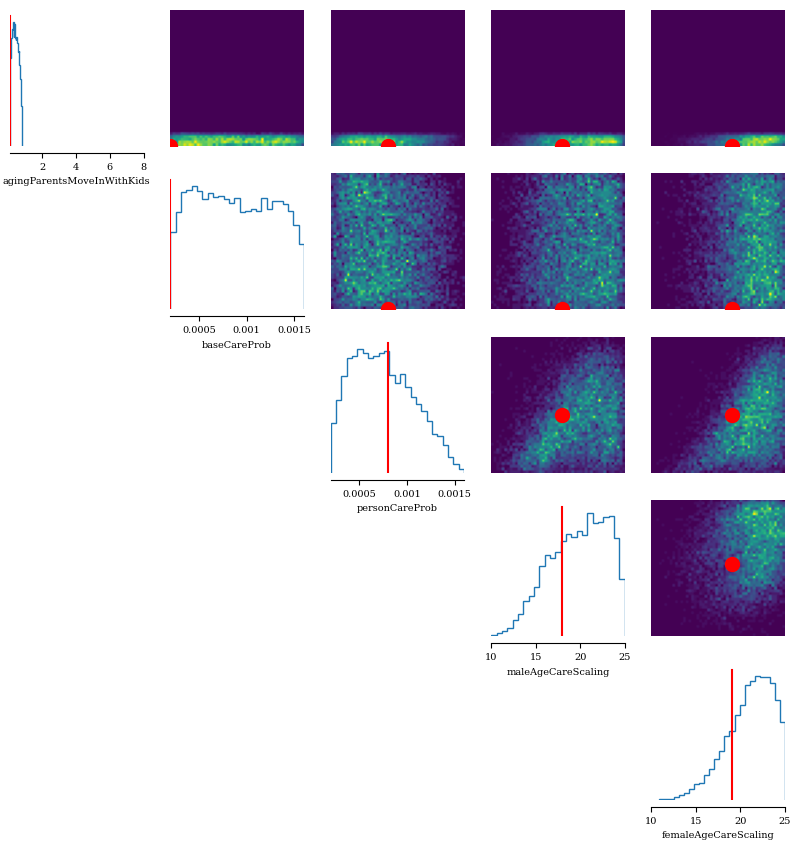

In [4]:
# maf_s (new arch) 10,000 samples
socialcare = np.loadtxt("../../exp_dir/socialcare/1715151754.033255/samples.txt")
plt.rcParams.update({'font.size':7}) # something about latex font
_ = analysis.pairplot(socialcare, limits=[[0.1,8], [0.0002, 0.0016], [0.0002, 0.0016], [10, 25], [10, 25]], 
                      points=[np.array([0.1, 0.0002, 0.0008, 18.0, 19.0])],
                      points_colors='r', labels=["agingParentsMoveInWithKids", "baseCareProb", "personCareProb", 
                                                 "maleAgeCareScaling", "femaleAgeCareScaling"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

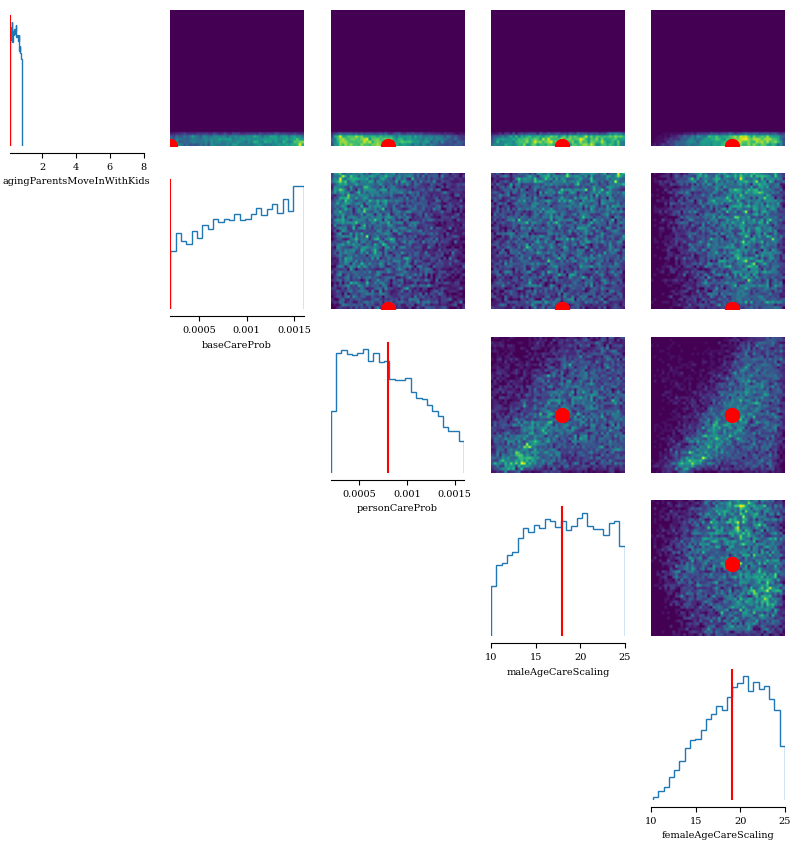

In [34]:
# maf_s (new arch) 100,000 samples
socialcare = np.loadtxt("../../exp_dir/socialcare/1715158835.9513047/samples.txt")
plt.rcParams.update({'font.size':7}) # something about latex font
_ = analysis.pairplot(socialcare, limits=[[0.1,8], [0.0002, 0.0016], [0.0002, 0.0016], [10, 25], [10, 25]], 
                      points=[np.array([0.1, 0.0002, 0.0008, 18.0, 19.0])],
                      points_colors='r', labels=["agingParentsMoveInWithKids", "baseCareProb", "personCareProb", 
                                                 "maleAgeCareScaling", "femaleAgeCareScaling"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

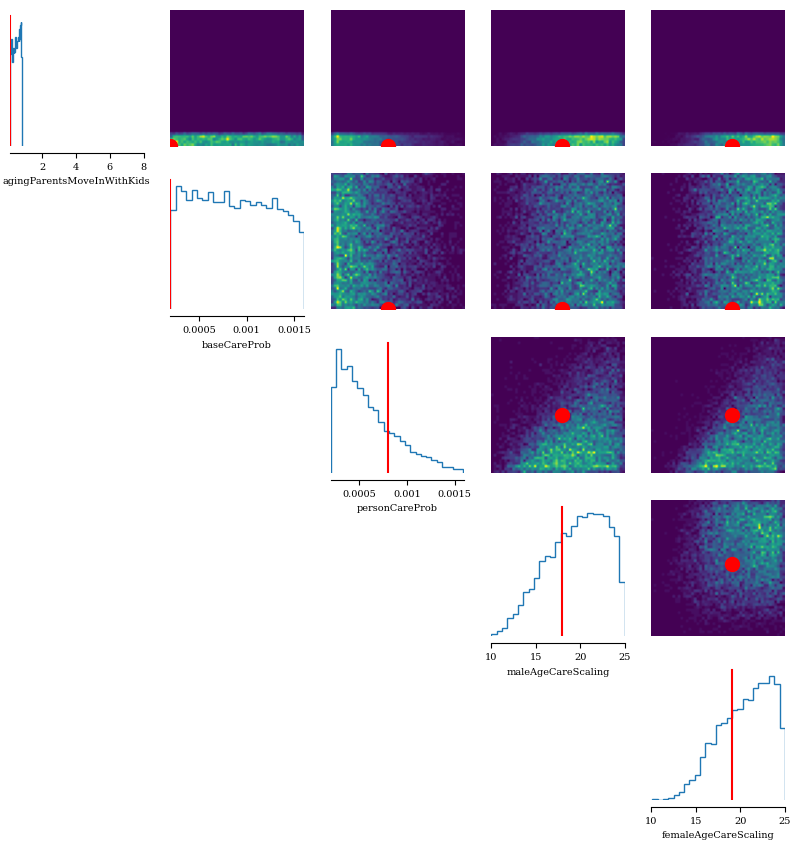

In [4]:
# maf_s (final new arch) 100,000 samples
socialcare = np.loadtxt("../../exp_dir/socialcare/1715970743.439267/samples.txt")
plt.rcParams.update({'font.size':7}) # something about latex font
_ = analysis.pairplot(socialcare, limits=[[0.1,8], [0.0002, 0.0016], [0.0002, 0.0016], [10, 25], [10, 25]], 
                      points=[np.array([0.1, 0.0002, 0.0008, 18.0, 19.0])],
                      points_colors='r', labels=["agingParentsMoveInWithKids", "baseCareProb", "personCareProb", 
                                                 "maleAgeCareScaling", "femaleAgeCareScaling"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

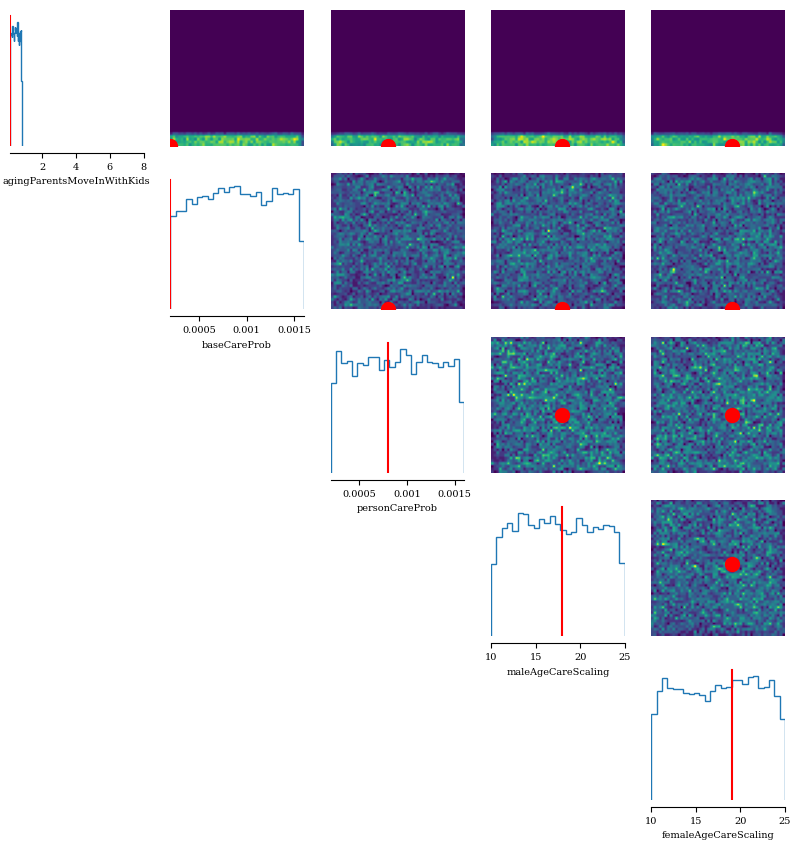

In [8]:
# maf_s (final new arch) 100,000 samples -> using final tax only
socialcare = np.loadtxt("../../exp_dir/socialcare/1716121654.4654644/samples.txt")
plt.rcParams.update({'font.size':7}) # something about latex font
_ = analysis.pairplot(socialcare, limits=[[0.1,8], [0.0002, 0.0016], [0.0002, 0.0016], [10, 25], [10, 25]], 
                      points=[np.array([0.1, 0.0002, 0.0008, 18.0, 19.0])],
                      points_colors='r', labels=["agingParentsMoveInWithKids", "baseCareProb", "personCareProb", 
                                                 "maleAgeCareScaling", "femaleAgeCareScaling"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

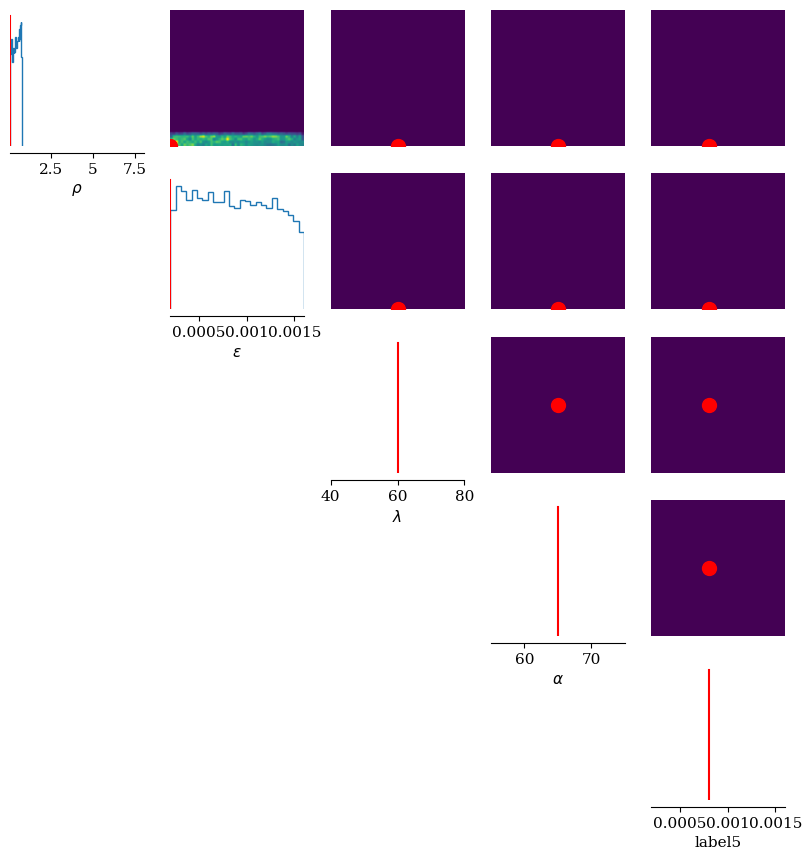

In [4]:
# maf_s (old arch) 100,000 samples
socialcare = np.loadtxt("../../exp_dir/socialcare/1715970743.439267/samples.txt")
plt.rcParams.update({'font.size':11}) # something about latex font
_ = analysis.pairplot(socialcare, limits=[[0.1,8], [0.0002, 0.0016], [40,80], [55, 75], [0.0002, 0.0016], [10, 25], [10, 25], [1, 10], [5, 50], [5, 40]], 
                      points=[np.array([0.1, 0.0002, 60.0, 65, 0.0008, 18.0, 19.0, 5.0, 30.0, 25.0])],
                      points_colors='r', labels=[r"$\rho$", r"$\epsilon$", r"$\lambda$", r"$\alpha$", "label5", "label6", "label7", "label8", "label9", "label10"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

# MAP

In [35]:
from sbi4abm.utils import io

socialcaref = io.load_task('socialcare')

file_name = "1715970743.439267"
with open(f"../../exp_dir/socialcare/{file_name}/posteriors.pkl", 'rb') as file:
    posterior = pickle.load(file)
    posterior = posterior[0]

In [36]:
# Define the negative log-posterior function for minimization
def neg_log_posterior(theta, posterior, observed_data):
    theta = torch.tensor(theta).float()
    return -posterior.log_prob(theta, x=observed_data).item()

In [38]:
from scipy.optimize import minimize

# observed data
final = socialcaref[2]
observation_tax = final[0]
observation_tax_years_average = final[1]
observations = torch.tensor([observation_tax, observation_tax_years_average])

initial_theta = socialcaref[1].mean.numpy()

# Optimize to find the MAP estimate
result = minimize(neg_log_posterior, initial_theta, args=(posterior, observations), method='L-BFGS-B')
map_estimate = result.x

print(f"MAP estimate: {map_estimate}")


MAP estimate: [4.50000018e-01 8.99999985e-04 8.99999985e-04 1.75000000e+01
 1.75000000e+01]


/home/pmms2/sbi4abm/py_env/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [39]:
true_theta = torch.tensor(socialcaref[3])
map_estimate = torch.tensor(map_estimate)
print(true_theta)
print(map_estimate)
loss = F.mse_loss(map_estimate, true_theta)
print(f"Loss between mean theta and true theta: {loss.item()}")

tensor([1.0000e-01, 2.0000e-04, 8.0000e-04, 1.8000e+01, 1.9000e+01],
       dtype=torch.float64)
tensor([4.5000e-01, 9.0000e-04, 9.0000e-04, 1.7500e+01, 1.7500e+01],
       dtype=torch.float64)
Loss between mean theta and true theta: 0.5245001025033902


In [40]:
y_star = socialcaref[0](map_estimate.tolist())
y_star = torch.tensor([y_star[0], y_star[1]])
print(y_star)


[0.45000001788139343, 0.0008999999845400453, 0.0008999999845400453, 17.5, 17.5]
tensor([11006.7744,  8832.2568])


In [41]:
import torch.nn.functional as F

def loss_function(simulated_output, observed_statistic):
    return F.mse_loss(simulated_output, observed_statistic)


# Compute the loss
loss = loss_function(y_star, observations)

print(f"Loss: {loss.item()}")

Loss: 13384731.301218031


# Mean

In [42]:
# Generate samples from the posterior
num_samples = 1000  # Number of samples to draw
posterior_samples = posterior.sample((num_samples,), x=observations)

# Compute the mean of the samples
mean_estimate = posterior_samples.mean(dim=0)
print(f"Mean estimate: {mean_estimate}")

Drawing 1000 posterior samples: 10145it [00:00, 13612.43it/s]                       

Mean estimate: tensor([4.7555e-01, 8.8684e-04, 5.9001e-04, 1.9588e+01, 2.0497e+01])


In [31]:
# Compute statistics about the sampled theta values
posterior_samples_np = posterior_samples.numpy()
mean_theta = np.mean(posterior_samples_np, axis=0)
std_theta = np.std(posterior_samples_np, axis=0)
lower_bound_theta = np.percentile(posterior_samples_np, 2.5, axis=0)
upper_bound_theta = np.percentile(posterior_samples_np, 97.5, axis=0)

print(f"Mean of theta: {mean_theta}")
print(f"Standard deviation of theta: {std_theta}")
print(f"95% credible interval for theta: [{lower_bound_theta}, {upper_bound_theta}]")

Mean of theta: [4.7200128e-01 8.7782624e-04 5.7529507e-04 1.9461729e+01 2.0440065e+01]
Standard deviation of theta: [2.0107022e-01 4.0834889e-04 2.9072026e-04 3.2599838e+00 2.8024817e+00]
95% credible interval for theta: [[1.34778712e-01 2.44570278e-04 2.20622538e-04 1.27536653e+01
 1.46597623e+01], [7.75161976e-01 1.55368386e-03 1.28943432e-03 2.44847019e+01
 2.46499369e+01]]


In [32]:
true_theta = torch.tensor(socialcaref[3])
mean_theta = torch.tensor(mean_theta)
print(true_theta)
print(mean_theta)
loss = F.mse_loss(mean_theta, true_theta)
print(f"Loss between mean theta and true theta: {loss.item()}")

tensor([1.0000e-01, 2.0000e-04, 8.0000e-04, 1.8000e+01, 1.9000e+01],
       dtype=torch.float64)
tensor([4.7200e-01, 8.7783e-04, 5.7530e-04, 1.9462e+01, 2.0440e+01])
Loss between mean theta and true theta: 0.8697651180264069


In [33]:
y_star = socialcaref[0](mean_estimate.tolist())
y_star = torch.tensor([y_star[0], y_star[1]])
print(y_star)

[0.472001314163208, 0.0008778260671533644, 0.0005752949509769678, 19.461746215820312, 20.440046310424805]


tensor([3386.1545, 3511.7820])


In [34]:
def loss_function(simulated_output, observed_statistic):
    return F.mse_loss(simulated_output, observed_statistic)


# Compute the loss
loss = loss_function(y_star, observations)

print(f"Loss: {loss.item()}")

Loss: 8498251.888487276


# Posterior Predictive Checks 

In [9]:
from sbi4abm.utils import io

socialcaref = io.load_task('socialcare')

In [10]:
idxs = np.random.randint(socialcare.shape[0], size=1000)

### Posterior Predictives

In [11]:
pps = []
for idx in idxs:
    data = socialcaref[0](list(socialcare[idx]))
    pps.append(data)

[0.7591390013694763, 0.0009543183841742575, 0.0011571404756978154, 11.492864608764648, 16.116296768188477]
[0.7468476295471191, 0.0015072490787133574, 0.001233797986060381, 11.439187049865723, 18.109149932861328]
[0.7614657282829285, 0.0004433357680682093, 0.0005048856255598366, 10.159767150878906, 22.46245002746582]
[0.3237648010253906, 0.001016011694446206, 0.0003496565914247185, 14.079628944396973, 19.991832733154297]
[0.4767073094844818, 0.0014300344046205282, 0.00039986224146559834, 19.944944381713867, 17.596723556518555]
[0.4937385618686676, 0.0015040452126413584, 0.0010205653961747885, 16.190889358520508, 18.27513313293457]
[0.612966775894165, 0.0015098779695108533, 0.0014874991029500961, 20.427492141723633, 22.520002365112305]
[0.5661980509757996, 0.0008473632042296231, 0.0015354629140347242, 15.317594528198242, 11.97248649597168]
[0.5599710941314697, 0.0015788688324391842, 0.00109712069388479, 21.07500648498535, 24.01904296875]
[0.13241352140903473, 0.0009776914957910776, 0.00

In [12]:
posterior_tax = []
posterior_per_capita_cost = []

for pp in pps:
    posterior_tax.append(pp[0])
    posterior_per_capita_cost.append(pp[1])


### Prior Predictives

In [13]:
pps_ = []
for idx in idxs:
    data = socialcaref[0](list(socialcaref[1].sample().tolist()))
    pps_.append(data)

[0.2982828617095947, 0.0005634669796563685, 0.0002821022644639015, 20.37828254699707, 14.472244262695312]


[0.3672860264778137, 0.0008892462938092649, 0.0011540618725121021, 20.47028923034668, 10.97794246673584]
[0.7791849374771118, 0.0014916458167135715, 0.00022458232706412673, 19.583812713623047, 24.18253517150879]
[0.5473564863204956, 0.001097374246455729, 0.0009647503029555082, 20.893787384033203, 14.504142761230469]
[0.6444451808929443, 0.0005313715664669871, 0.0003523773921187967, 15.583938598632812, 16.122222900390625]
[0.48730871081352234, 0.0013775635743513703, 0.0002662375627551228, 10.943326950073242, 14.265745162963867]
[0.12795236706733704, 0.0015146565856412053, 0.0010335507104173303, 17.92778968811035, 22.566516876220703]
[0.7998760938644409, 0.0012966205831617117, 0.00021095527336001396, 16.041730880737305, 21.64735984802246]
[0.1843964159488678, 0.000963483180385083, 0.0010479793418198824, 11.355629920959473, 10.446308135986328]
[0.2960740327835083, 0.0008193539688363671, 0.0010807514190673828, 24.928592681884766, 17.517189025878906]
[0.25436684489250183, 0.0005049509927630

In [14]:
prior_tax = []
prior_per_capita_cost = []

for pp in pps_:
    prior_tax.append(pp[0])
    prior_per_capita_cost.append(pp[1])


### Observation

In [15]:
final = socialcaref[2]
observation_tax = final[0]
observation_per_capita_cost = final[1]

### Plots

In [16]:
from matplotlib.lines import Line2D
import matplotlib.patches as patches

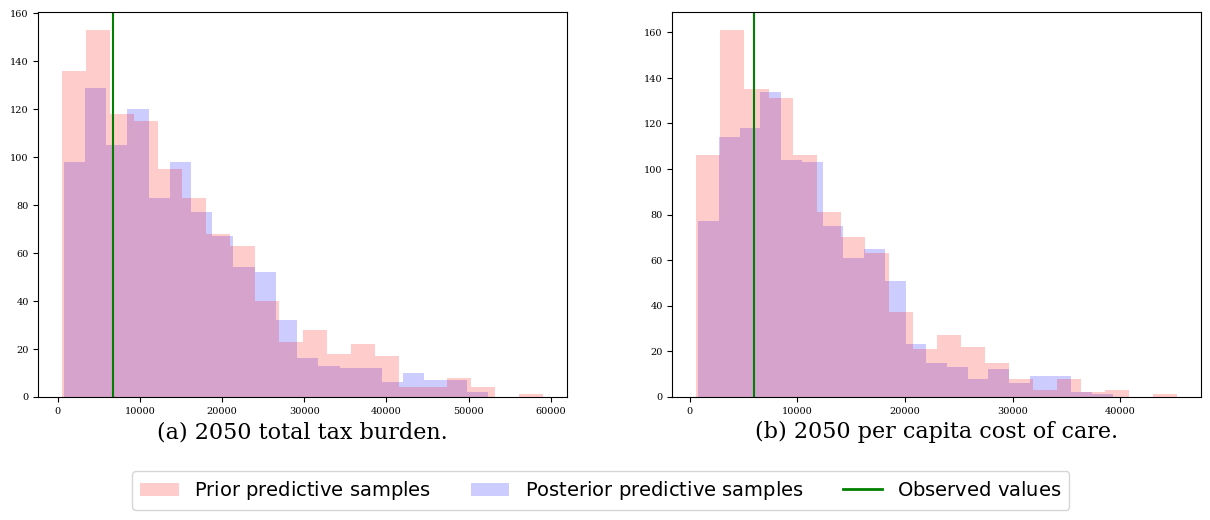

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(posterior_tax, bins=20, color='b', alpha=0.2)
axes[0].hist(prior_tax, bins=20, color='r', alpha=0.2)
axes[0].axvline(observation_tax, c='g')
axes[0].set_xlabel(r"(a) 2050 total tax burden.", fontsize=16)

axes[1].hist(posterior_per_capita_cost, bins=20, color='b', alpha=0.2)
axes[1].hist(prior_per_capita_cost, bins=20, color='r', alpha=0.2)
axes[1].axvline(observation_per_capita_cost, c='g')
axes[1].set_xlabel(r"(b) 2050 per capita cost of care.", fontsize=16)

handles = [patches.Rectangle((0,0),0,0,facecolor='r',
                             label=r"${\rm Prior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           patches.Rectangle((0,0),0,0,facecolor='b',
                             label=r"${\rm Posterior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           Line2D([0], [0], color='g', label=r"${\rm Observed}$ ${\rm values}$", lw=2, linestyle="-")]

# fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=18)
fig.legend(handles=handles, bbox_to_anchor=(0.5, -0.02), loc='upper center', ncol=3, fontsize=14)

# plt.savefig("./overleaf_plots/graph_posterior_predictives.png", dpi=1000, format='png', bbox_inches='tight')